# Example notebook: Fisher forecast 

Authors: Sambit Giri, Adélie Gorce, Ian Hothi

Date: June 2025

In this notebook, we show how to obtain Fisher results from statistics pre-computed on the simulation dataset with the `compute_statistic` script.

In [1]:
import numpy as np
import h5py
import tqdm
import matplotlib.pyplot as plt
from matplotlib import colors
import corner

import os
import glob
import numpy as np

# About the data

The data has been simulated using 21cmFast. The XY plane has an extent of 250Mpc, with 256 pixels on each side. The line-of-sight (redshift) has been simulated to be between z = 8.82 (144.60 MHz) and z = 9.33 (137.46 MHz), comprising 128 frequency channels. The three parameters chosen to be changed are the virial temperature, maximum bubble size, and the ionising efficiency parameter—these were all found to have the strongest impact on the signal. 

These are the parameter variations (fiducial value $\pm$ change):

- $T_{Vir}$: $50000\pm 5000$
- $R_{Max}$: $15\pm 5 Mpc$
- $\zeta$: $30\pm 5$,
400 simulations were run for each parameter value, which will be used for the derivatives. In the loaded files, there will be two files for each parameter, one corresponding to the plus value - for example, for $T_{Vir}$ tue value would be 50000 + 5000. Whereas the minus value would be 50000 - 5000.


400 simulations were run with the fiducial values, this will serve to calculate the covariances of the statistics.




In [2]:
# Folder where the data is stored
# ddir = '/data/cluster/agorce/SKA_chapter_simulations/'
ddir = '../SKA_chapter_simulations/' # This folder can be created inside the repository folder. It will be ignored during the git commit.
# File with fiducial lightcone
file = ddir+'Lightcone_FID_400_Samples.h5'

In [3]:
statname = 'ps'

## Global parameters

In [ ]:
# cosmology
h = 0.6774

In [4]:
# Astro params
params = ['ION_Tvir_MIN','R_BUBBLE_MAX','HII_EFF_FACTOR']
Fisher_Param = ['$T_{Vir}$','$R_{Max}$','$\zeta$']
nparams = len(params)
# parameter values for fiducial simulation
fid = [pow(10,4.7),15,30]
# parameter range for derivatives
delta_params = [pow(10,4.740362689494244)-pow(10,4.653212513775344), 10, 10]

# Power spectrum params
nbins = 15

In [5]:
# simulation files
files = [ddir+'Lightcone_FID_400_Samples.h5']
[files.extend(
    [f'{ddir}Lightcone_{p}_400_Samples_Plus.h5', f'{ddir}Lightcone_{p}_400_Samples_Minus.h5']) for p in params]
print(files)

['./SKA_chapter_simulations/Lightcone_FID_400_Samples.h5', './SKA_chapter_simulations/Lightcone_ION_Tvir_MIN_400_Samples_Plus.h5', './SKA_chapter_simulations/Lightcone_ION_Tvir_MIN_400_Samples_Minus.h5', './SKA_chapter_simulations/Lightcone_R_BUBBLE_MAX_400_Samples_Plus.h5', './SKA_chapter_simulations/Lightcone_R_BUBBLE_MAX_400_Samples_Minus.h5', './SKA_chapter_simulations/Lightcone_HII_EFF_FACTOR_400_Samples_Plus.h5', './SKA_chapter_simulations/Lightcone_HII_EFF_FACTOR_400_Samples_Minus.h5']


Parameters describing the simulations:

In [ ]:
# Read h5py file for metadata
with h5py.File(files[0], 'r') as f:
    frequencies = f['frequencies'][...]
    redshifts = f['redshifts'][...]
    box_length = float(f['box_length'][0])/h  # Mpc
    box_dim = int(f['ngrid'][0])
    n_samp = int(f['nrealisations'][0])
nfreq = frequencies.size
print(f'Lightcone runs from z={redshifts.min():.2f} to z = {redshifts.max():.2f}.')

Lightcone runs from z=8.82 to z = 9.33.


In [7]:
dk = 2.*np.pi/box_length
k_nyquist = dk*box_dim/2.

# Loading Data and Statistics estimation 

In [8]:
# container dict: keys will be e.g. 'PS_param_1_plus', 'PS_fid', etc.
PS_data = {}
keys = []
count = 0
for fpath in tqdm.tqdm(files):

    key = os.path.basename(fpath)[:-3].replace('Lightcone_', '').replace('_400_Samples', '')
    keys.append(key)
    try:
        with h5py.File(fpath, 'r') as f:
            ks = f['bins'][...]
            mask = ks < k_nyquist
            PS_data[key] = {
                'ps_clean':  f['ps_clean'][:, mask],  # ps of clean cosmological signal
                'ks':  f['bins'][mask],
            }
            if 'FID' in key:
                PS_data[key].update({
                    'ps_noise':  f['ps_noise'][:, mask],  # ps of noise
                    'ps_obs':  f['ps_obs'][:, mask],  # ps of smoothed (noise + cosmological signal)
                })
    except KeyError:
        PS_data[key] = {}
        PS_data[key]['ps_clean'] = np.zeros((n_samp, nbins))
        PS_data[key]['ps_noise'] = np.zeros((n_samp, nbins))
        PS_data[key]['ps_obs'] = np.zeros((n_samp, nbins))
        PS_data[key]['ks'] = np.zeros(nbins)
        count += 1

# now you can refer to, e.g. PS_data['PS_R_BUBBLE_MAX_plus']['PS'] 
# and PS_data['PS_R_BUBBLE_MAX_plus']['ks'] etc.
print(f'Found {len(PS_data)} {statname} datasets, {count} missing.')

# Example: check shapes
for name, dat in PS_data.items():
    print(f"{name:25s} → PS {dat['ps_clean'].shape},  ks {dat['ks'].shape}")


100%|██████████| 7/7 [00:00<00:00, 16.27it/s]

Found 7 ps datasets, 0 missing.
FID                       → PS (400, 13),  ks (13,)
ION_Tvir_MIN_Plus         → PS (400, 13),  ks (13,)
ION_Tvir_MIN_Minus        → PS (400, 13),  ks (13,)
R_BUBBLE_MAX_Plus         → PS (400, 13),  ks (13,)
R_BUBBLE_MAX_Minus        → PS (400, 13),  ks (13,)
HII_EFF_FACTOR_Plus       → PS (400, 13),  ks (13,)
HII_EFF_FACTOR_Minus      → PS (400, 13),  ks (13,)


In [9]:
for fpath in tqdm.tqdm(files):
    with h5py.File(fpath, 'r') as f:
        ks = f['bins'][...]
        print(fpath,len(ks))

100%|██████████| 7/7 [00:00<00:00, 409.46it/s]

./SKA_chapter_simulations/Lightcone_FID_400_Samples.h5 15
./SKA_chapter_simulations/Lightcone_ION_Tvir_MIN_400_Samples_Plus.h5 15
./SKA_chapter_simulations/Lightcone_ION_Tvir_MIN_400_Samples_Minus.h5 15
./SKA_chapter_simulations/Lightcone_R_BUBBLE_MAX_400_Samples_Plus.h5 15
./SKA_chapter_simulations/Lightcone_R_BUBBLE_MAX_400_Samples_Minus.h5 15
./SKA_chapter_simulations/Lightcone_HII_EFF_FACTOR_400_Samples_Plus.h5 15
./SKA_chapter_simulations/Lightcone_HII_EFF_FACTOR_400_Samples_Minus.h5 15


## Fisher Matrix

Under the assumption that the likelihood is a multivariate Gaussian (mean vectors are sufficient information for the covariance matrix), the Fisher matrix is defined as:

$$F^\theta_{ij} = \frac{\partial \textbf{S}}{\partial\theta_i} \mathbf{\Sigma}^{-1} \frac{\partial \textbf{S}}{\partial\theta_j},$$

where  $\frac{\partial \textbf{S}}{\partial\theta_i}$ is the change in statistic S under a change in paramrter i of $\partial\theta_j$. Here, $\mathbf{\Sigma}$ is the the covariance matrix, given my the fiducial simulation set.


### Derivatives

Let us first calculate $\frac{\partial \textbf{S}}{\partial\theta_i}$ for out three astrophysical parameters:

In [10]:
# Compute the finite‐difference derivatives for each k‐bin & sample
# from the statistics derived from the clean signal
dPS = {}
PS_derivs = np.zeros((len(params), n_samp, mask.sum()))
for ip, param in enumerate(params):
    dPS[param] = (PS_data[f'{param}_Plus']['ps_clean'] - PS_data[f'{param}_Minus']['ps_clean']) / delta_params[ip]
    PS_derivs[ip] = (PS_data[f'{param}_Plus']['ps_clean'] - PS_data[f'{param}_Minus']['ps_clean']) / delta_params[ip]
ks = PS_data[f'{param}_Plus']['ks']

print(dPS['R_BUBBLE_MAX'].shape)

(400, 13)


### Data covariance

The data covariance will have two contributions: 
1. Statistical errors coming from the sample variance of your estimator (variance computed across the statistics estimated from a number of realisations of a clea simulation).
2. Noise errors coming from instrumental (SKA AA* layout) noise

We obtain the data covariance from 400 realisations of the "observed" maps.

Let us whiten the data to get rid of any order of magnitude issues that may arise (note that this leads to the covariance having a diagonal of ones):

In [11]:
## Whitening step ##
PS_fid = PS_data['FID']['ps_obs'] 
std_fid = np.std(PS_fid, axis=0)

# remove modes above smoothing limit where there is no variance
mask = std_fid > 0.
white_fid = PS_fid[:, mask]/std_fid[mask]
kbins = PS_data['FID']['ks'][mask]
# Whitening the derivatives
PS_derivs_white = PS_derivs[..., mask]/std_fid[mask]

In [12]:
covariance = np.cov(white_fid, rowvar=False)
# Check the condition of the covariance to ensure numerical inversion is stable:
print(f'log Condition number of the covariance matrix: {np.log10(np.linalg.cond(covariance)):.2f} (should be <= 7).')

log Condition number of the covariance matrix: 0.84 (should be <= 7).


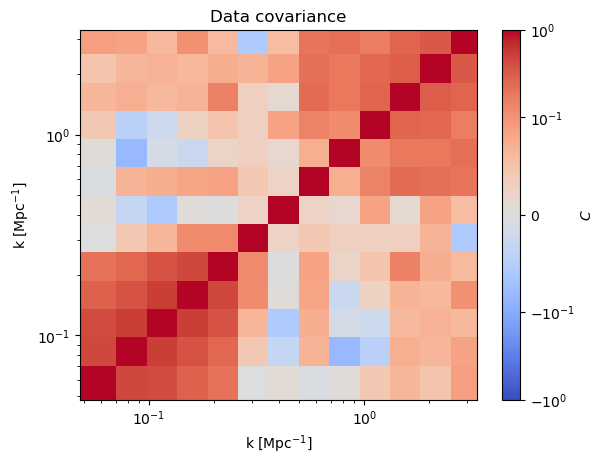

In [13]:
plt.figure()
plt.pcolormesh(kbins, kbins, covariance, cmap='coolwarm', norm=colors.SymLogNorm(linthresh=.1, vmin=-1., vmax=1.))
plt.xscale('log')
plt.yscale('log')
plt.title('Data covariance')
plt.xlabel('k [Mpc$^{-1}$]')
plt.ylabel('k [Mpc$^{-1}$]')
plt.colorbar(label=r'$C$')

Let us check the stability of the inversion:

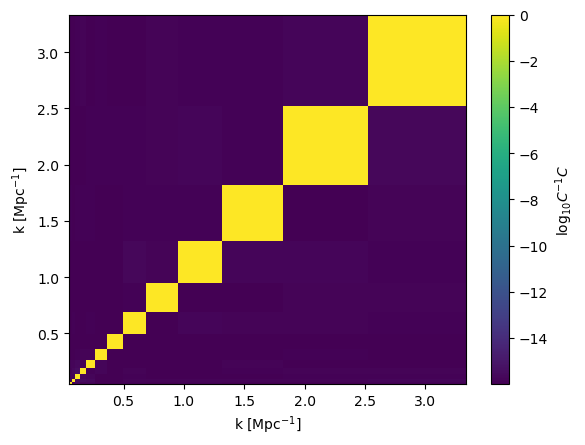

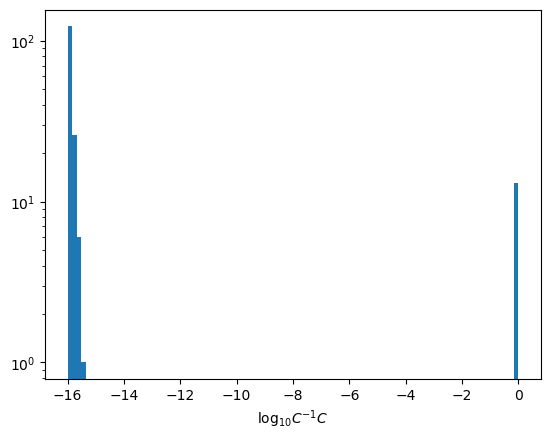

In [14]:
# Checking stability of the covariance by looking at the value of the off-diagonal terms of Sigma dot Sigma-1
I = np.log10(abs(np.matmul(np.linalg.inv(covariance), covariance))+1e-16)

plt.figure()
plt.pcolormesh(kbins, kbins, I)
plt.colorbar().set_label('log$_{10} C^{-1}C$')
plt.xlabel('k [Mpc$^{-1}$]')
plt.ylabel('k [Mpc$^{-1}$]')

plt.figure()
plt.hist(I[I!=1.].reshape(-1), bins=100)
plt.xlabel('log$_{10} C^{-1}C$')
plt.yscale('log')


We can now calculate the Fisher Matrix for different sub-samples to check convergence

In [15]:
# Number of realisations to look at when checking convergence
samples = np.arange(5, n_samp+5, 5)

# Initialising Fishers 
PS_Fisher = np.zeros((samples.size, nparams, nparams))
PS_Fisher_Inv = np.zeros((samples.size, nparams, nparams))

In [16]:
# Calculating the Fisher matrix for a given sample of derivatives 
for k, sample_size in enumerate(samples):
    deriv_sample = np.mean(PS_derivs_white[:, :sample_size, :], axis=1)
    for i in range(nparams):
        for j in range(nparams):  
            PS_Fisher[k, i, j] = np.dot(deriv_sample[i], np.dot(np.linalg.inv(covariance), deriv_sample[j]))
    PS_Fisher_Inv[k] = np.linalg.inv(PS_Fisher[k])

Text(0.5, 1.0, 'Convergence of the Fisher inverse matrix diagonal elements')

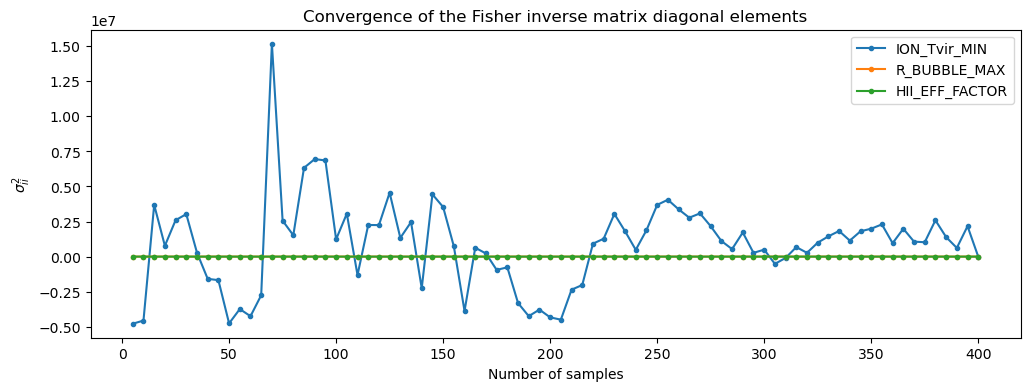

In [17]:
plt.figure(figsize=(12, 4))
for i, param in enumerate(params):
    plt.plot(samples, [np.diag(PS_Fisher_Inv[k])[i]-np.diag(PS_Fisher_Inv[-1])[i] for k in range(samples.size)], marker='.', label=param)
plt.legend()
plt.ylabel(r'$\sigma^2_{ii}$')
plt.xlabel('Number of samples')
plt.title('Convergence of the Fisher inverse matrix diagonal elements')


### Plot and save posterior

Plot the resulting Gaussian distribution with appropriate covariance

In [18]:
fisher_data = np.random.multivariate_normal(fid, PS_Fisher_Inv[-1], size=100000)

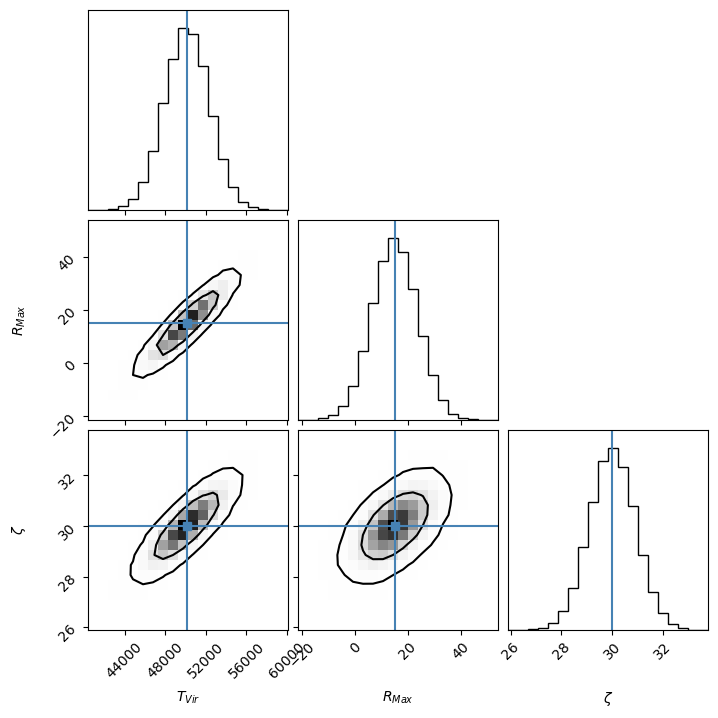

In [19]:
_ = corner.corner(
    fisher_data,
    labels=Fisher_Param,
    plot_datapoints=False,  
    levels=(0.68,0.95),
    truths=fid)

If the above corner plot looks fine, then save the (3,3) covariance matrix.

In [20]:
np.savetxt('./output/posterior_covariance_matrix_AAstar_1000hours_PS1d.txt', PS_Fisher_Inv[-1])